In [18]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from numpy.random import seed
from qkeras import qlayers, qconvolutional
from qkeras.qlayers import QActivation
from qkeras.qconvolutional import QConv2D
from qkeras.quantizers import quantized_bits, quantized_relu

In [19]:
seed(0)
tf.random.set_seed(0)

In [20]:
#DEFINE AND AUGMENT TRAIN DATA
train_ds = tf.keras.utils.image_dataset_from_directory(
    './Datasheet_RPS/train',
    labels='inferred',
    label_mode='int',
    class_names=None,
    batch_size=32,
    image_size=(30, 30),
    shuffle=True,
    seed=10,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 2529 files belonging to 3 classes.


In [21]:
#DEFINE AND AUGMENT VALIDATION DATA
val_ds = tf.keras.utils.image_dataset_from_directory(
    './Datasheet_RPS/valid',
    labels='inferred',
    label_mode='int',
    class_names=None,
    batch_size=32,
    image_size=(30, 30),
    shuffle=True,
    seed=10,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 372 files belonging to 3 classes.


In [22]:
#DEFINE AND AUGMENT TEST DATA
test_ds = tf.keras.utils.image_dataset_from_directory(
    './Datasheet_RPS/test',
    labels='inferred',
    label_mode='int',
    class_names=None,
    batch_size=32,
    image_size=(30, 30),
    shuffle=True,
    seed=10,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 41 files belonging to 3 classes.


In [23]:

#NORMALIZATION
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))


In [24]:

#CREATE MODEL
model = keras.Sequential()

model.add(qconvolutional.QConv2D(
    90,
    3,
    input_shape=(30,30,3),
    kernel_quantizer=quantized_bits(7, 1, alpha=1),
    bias_quantizer=quantized_bits(7, 1, alpha=1),
    ))

model.add(QActivation(activation=quantized_relu(7), name='relu1'))

model.add(layers.MaxPooling2D())

model.add(qconvolutional.QConv2D(
    64,
    3,
    kernel_quantizer=quantized_bits(7, 1, alpha=1),
    bias_quantizer=quantized_bits(7, 1, alpha=1),
    ))

model.add(QActivation(activation=quantized_relu(6), name='relu2'))

model.add(layers.MaxPooling2D())

model.add(qconvolutional.QConv2D(
    32,
    3,
    kernel_quantizer=quantized_bits(7, 1, alpha=1),
    bias_quantizer=quantized_bits(7, 1, alpha=1),
    ))

model.add(QActivation(activation=quantized_relu(7), name='relu3'))

model.add(layers.MaxPooling2D())

model.add(layers.Flatten())

model.add(qlayers.QDense(
    64,
    kernel_quantizer=quantized_bits(7, 1, alpha=1),
    bias_quantizer=quantized_bits(7, 1, alpha=1),
    ))

model.add(QActivation(activation=quantized_relu(7), name='relu4'))

model.add(qlayers.QDense(
    3,
    kernel_quantizer=quantized_bits(1, 1, alpha=1),
    bias_quantizer=quantized_bits(1, 1, alpha=1),
    ))


In [25]:

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning, PruningSummaries

pruning_params = {

    "pruning_schedule": pruning_schedule.PolynomialDecay(
    initial_sparsity = 0,
    final_sparsity = .9,
    begin_step = 100,
    end_step = 1200,
    power=1.2,
    frequency=100)
    

    }
model = prune.prune_low_magnitude(model, **pruning_params)


In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_q_conv2  (None, 28, 28, 90)       4952      
 d_3 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_relu1 (  (None, 28, 28, 90)       1         
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_max_poo  (None, 14, 14, 90)       1         
 ling2d_3 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_q_conv2  (None, 12, 12, 64)       103746    
 d_4 (PruneLowMagnitude)                                         
                                                      

In [27]:
optimizer=tf.keras.optimizers.Adam()
optimizer.learning_rate.assign(0.0008)

call = []
call.append(pruning_callbacks.UpdatePruningStep())

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

In [28]:
epochs=20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=call
)
model = strip_pruning(model)

Epoch 1/20
80/80 [==============================] - 8s 45ms/step - loss: 0.9306 - accuracy: 0.5741 - val_loss: 0.7551 - val_accuracy: 0.7366
Epoch 2/20
80/80 [==============================] - 3s 33ms/step - loss: 0.2841 - accuracy: 0.9423 - val_loss: 0.5341 - val_accuracy: 0.7957
Epoch 3/20
80/80 [==============================] - 3s 33ms/step - loss: 0.2524 - accuracy: 0.9245 - val_loss: 1.1027 - val_accuracy: 0.6263
Epoch 4/20
80/80 [==============================] - 3s 33ms/step - loss: 0.1394 - accuracy: 0.9703 - val_loss: 0.7915 - val_accuracy: 0.7715
Epoch 5/20
80/80 [==============================] - 3s 33ms/step - loss: 0.0685 - accuracy: 0.9909 - val_loss: 1.4972 - val_accuracy: 0.5323
Epoch 6/20
80/80 [==============================] - 3s 33ms/step - loss: 0.0750 - accuracy: 0.9870 - val_loss: 0.9916 - val_accuracy: 0.6747
Epoch 7/20
80/80 [==============================] - 3s 33ms/step - loss: 0.2598 - accuracy: 0.9304 - val_loss: 0.6494 - val_accuracy: 0.7339
Epoch 8/20
80

% of zeros = 0.9


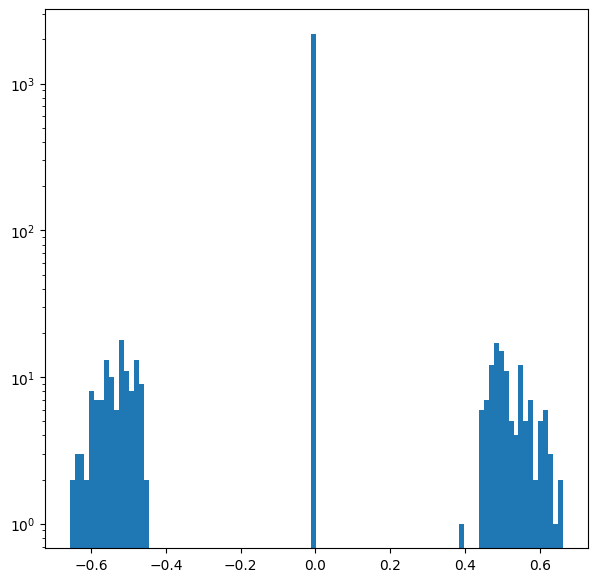

In [29]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7, 7))
plt.bar(b[:-1], h, width=b[1] - b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

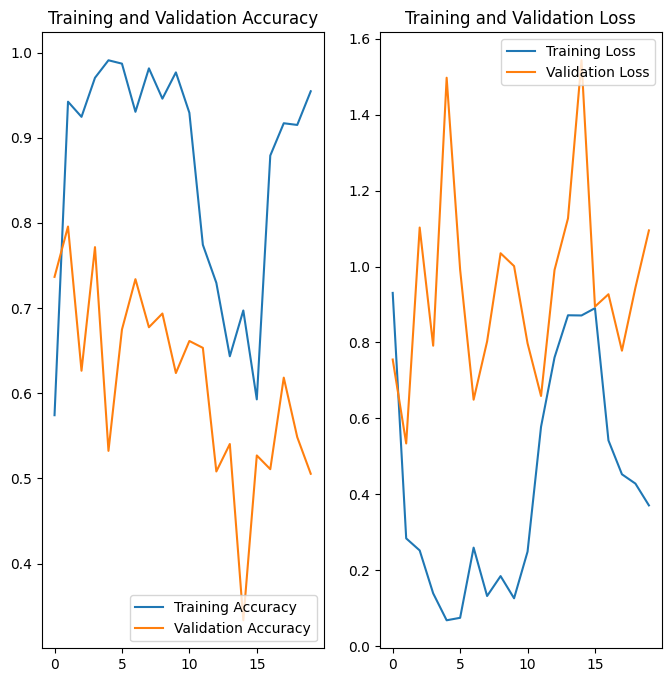

0.5573476751645406


In [30]:
epochs=epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print((val_acc[-1] + val_acc[-2] + val_acc[-3])/3)

In [31]:

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

In [32]:
model.evaluate(test_ds)

2/2 [==============================] - 1s 9ms/step - loss: 0.5573 - accuracy: 0.7561


[0.557265043258667, 0.7560975551605225]